# Combined Features & Weighted Similarity Models

**By Aziz Presswala**

In [24]:
!ls "drive/My Drive/ML_data"

16k_apperal_data	       16k_data_cnn_feature_asins.npy  word2vec_model
16k_apperal_data_preprocessed  16k_data_cnn_features.npy


In [15]:
# importing libraries
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### Loading Product Data

In [16]:
data = pd.read_pickle('drive/My Drive/ML_data/16k_apperal_data_preprocessed')
data.head()

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


In [17]:
data.shape

(16042, 7)

### IDF weighted Word2Vec on Product Title

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

with open('drive/My Drive/ML_data/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [0]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [0]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

In [33]:
# shape of the idf-based avg w2v vectors
print('Shape of idf-based avg w2v features', w2v_title_weight.shape)

Shape of idf-based avg w2v features (16042, 300)


### One Hot Encoding for Product Brand & Color

In [36]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)
print('Shape of brand features',brand_features.shape)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)
print('Shape of color features',color_features.shape)

Shape of brand features (16042, 3835)
Shape of color features (16042, 1845)


### Features extracted from Product Images using CNN (VGG16)

In [35]:
bottleneck_features_train = np.load('drive/My Drive/ML_data/16k_data_cnn_features.npy')
asins = np.load('drive/My Drive/ML_data/16k_data_cnn_feature_asins.npy')
asins = list(asins)
df_asins = list(data['asin'])
print('Shape of image features',bottleneck_features_train.shape)

Shape of image features (16042, 25088)


### Weighted Similarity using Product Title, Brand, Color & Image features

In [0]:
from IPython.display import display, Image, SVG, Math, YouTubeVideo

def all_features(doc_id, wt, wb, wc, wi, num_results=20):
    #--------------About the parameters----------------------------------#
    # doc_id: apparel's id in given corpus
    # wt: weight for idf-based w2v features
    # wb: weight for brand features
    # wc: weight for color features
    # wi: weight for image features
    # num_results: number of similar products to be returned (default=20)
    #--------------------------------------------------------------------#
    
    doc_id = asins.index(df_asins[doc_id])

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    brand_feat_dist = pairwise_distances(brand_features, brand_features[doc_id])
    color_feat_dist = pairwise_distances(color_features, color_features[doc_id])
    image_feat_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    pairwise_dist   = (wt * idf_w2v_dist +  wb * brand_feat_dist + wc * color_feat_dist + wi * image_feat_dist)/float(wt + wb + wc + wi)

    # np.argsort will return indices of 20 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    
    #pdists will store the 20 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #data frame indices of the 20 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])
            print('='*125)

#### Equal weights to all features

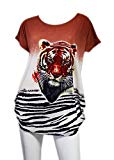

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 1.5814899597899058e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


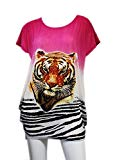

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 9.671943096059518
Amazon Url: www.amzon.com/dp/B00JXQASS6


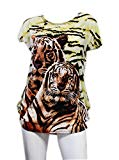

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 12.599729372882209
Amazon Url: www.amzon.com/dp/B00JXQCUIC


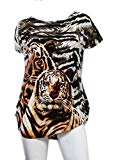

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 13.352637793535298
Amazon Url: www.amzon.com/dp/B00JXQCWTO


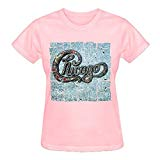

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 13.970511722745385
Amazon Url: www.amzon.com/dp/B01GXAZTRY


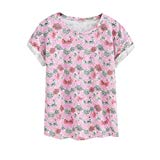

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 13.98926689805921
Amazon Url: www.amzon.com/dp/B071FCWD97


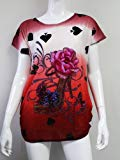

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 14.03401434602674
Amazon Url: www.amzon.com/dp/B00JV63QQE


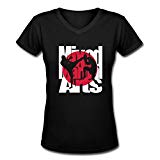

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 14.106718279832904
Amazon Url: www.amzon.com/dp/B01JQ096HW


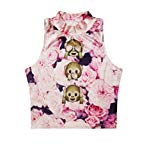

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 14.13693154048354
Amazon Url: www.amzon.com/dp/B015H3W9BM


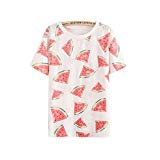

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 14.141548182391485
Amazon Url: www.amzon.com/dp/B01JUNHBRM


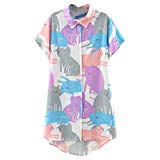

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 14.185003948302015
Amazon Url: www.amzon.com/dp/B01CR57YY0


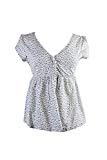

Product Title:  denim  supply ralph lauren womens floral print scalloped blouse multi 
Euclidean Distance from input image: 14.198662567229016
Amazon Url: www.amzon.com/dp/B06XG3CP9S


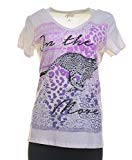

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 14.20861065577895
Amazon Url: www.amzon.com/dp/B01CUPYBM0


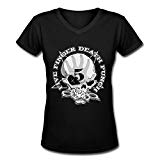

Product Title:  five finger death punch womens pink print 2014 tour girls jr soft tee black 
Euclidean Distance from input image: 14.211189079375012
Amazon Url: www.amzon.com/dp/B0148ROP3S


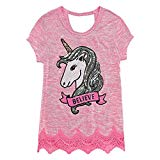

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 14.281768945501966
Amazon Url: www.amzon.com/dp/B0177DM70S


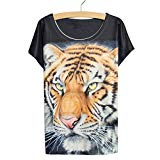

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 14.284128405565326
Amazon Url: www.amzon.com/dp/B010NN9RXO


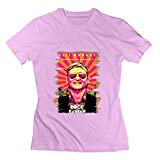

Product Title:  womens rock kasbah movie bill murray tshirts casual pink size l 
Euclidean Distance from input image: 14.297124290556653
Amazon Url: www.amzon.com/dp/B017N7DWYI


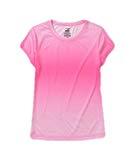

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 14.301490713977179
Amazon Url: www.amzon.com/dp/B01F7PHXY8


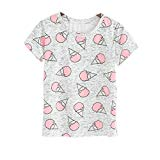

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 14.305999425696058
Amazon Url: www.amzon.com/dp/B0734GRKZL


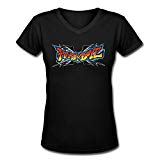

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Euclidean Distance from input image: 14.307173398779554
Amazon Url: www.amzon.com/dp/B01A82FFBI


In [48]:
all_features(12566, 5, 5, 5, 5)

#### More weight to title and image features

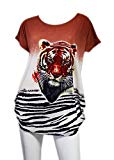

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 3.1629799195798116e-06
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


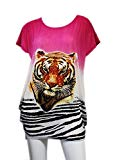

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 16.76915237575291
Amazon Url: www.amzon.com/dp/B00JXQASS6


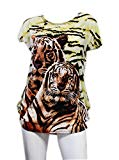

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 22.6254879863355
Amazon Url: www.amzon.com/dp/B00JXQCUIC


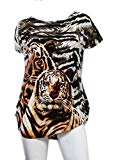

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 24.193943529889705
Amazon Url: www.amzon.com/dp/B00JXQCWTO


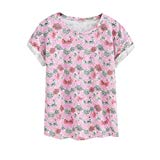

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 25.517206087836964
Amazon Url: www.amzon.com/dp/B071FCWD97


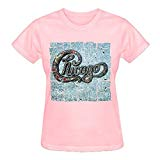

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 25.87564991004542
Amazon Url: www.amzon.com/dp/B01GXAZTRY


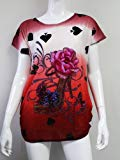

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 25.928296747932183
Amazon Url: www.amzon.com/dp/B00JV63QQE


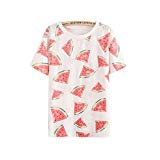

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 25.9671311290357
Amazon Url: www.amzon.com/dp/B01JUNHBRM


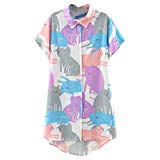

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 25.992299308812996
Amazon Url: www.amzon.com/dp/B01CR57YY0


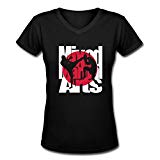

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 26.02365525321734
Amazon Url: www.amzon.com/dp/B01JQ096HW


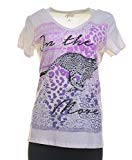

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 26.030376177594782
Amazon Url: www.amzon.com/dp/B01CUPYBM0


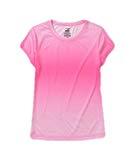

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 26.03574627948736
Amazon Url: www.amzon.com/dp/B01F7PHXY8


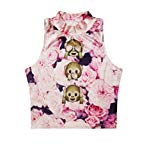

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 26.069746428296686
Amazon Url: www.amzon.com/dp/B015H3W9BM


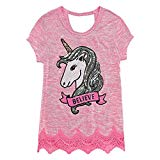

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 26.071546918410746
Amazon Url: www.amzon.com/dp/B0177DM70S


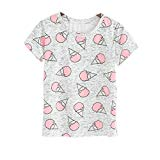

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 26.18597009803721
Amazon Url: www.amzon.com/dp/B0734GRKZL


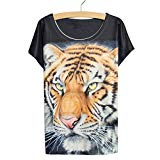

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 26.201572352216363
Amazon Url: www.amzon.com/dp/B010NN9RXO


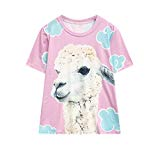

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 26.20727459106004
Amazon Url: www.amzon.com/dp/B01I80A93G


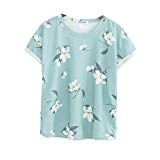

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 26.217594843671442
Amazon Url: www.amzon.com/dp/B071SBCY9W


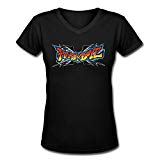

Product Title:  cling womens hardy boyz wwe logo vneck tshirt black 
Euclidean Distance from input image: 26.243667394179788
Amazon Url: www.amzon.com/dp/B01A82FFBI


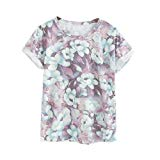

Product Title:  kawaii cotton pastel tops tees pink flower design 
Euclidean Distance from input image: 26.318894368667095
Amazon Url: www.amzon.com/dp/B071P4YKH5


In [54]:
all_features(12566, 3, 1, 1, 5)

#### More weight to brand and color features

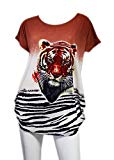

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 7.907449912636366e-07
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


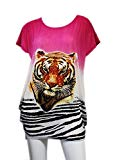

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 5.894988554325636
Amazon Url: www.amzon.com/dp/B00JXQASS6


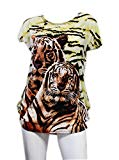

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 7.232877579068187
Amazon Url: www.amzon.com/dp/B00JXQCUIC


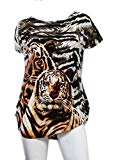

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 7.4628850726996445
Amazon Url: www.amzon.com/dp/B00JXQCWTO


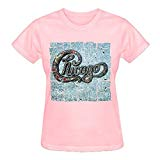

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 7.692362654480169
Amazon Url: www.amzon.com/dp/B01GXAZTRY


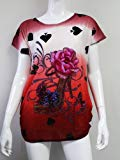

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 7.700019862984661
Amazon Url: www.amzon.com/dp/B00JV63QQE


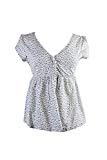

Product Title:  denim  supply ralph lauren womens floral print scalloped blouse multi 
Euclidean Distance from input image: 7.702884757654284
Amazon Url: www.amzon.com/dp/B06XG3CP9S


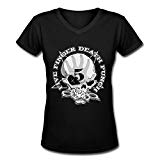

Product Title:  five finger death punch womens pink print 2014 tour girls jr soft tee black 
Euclidean Distance from input image: 7.709148132936572
Amazon Url: www.amzon.com/dp/B0148ROP3S


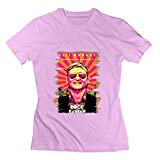

Product Title:  womens rock kasbah movie bill murray tshirts casual pink size l 
Euclidean Distance from input image: 7.752115452425097
Amazon Url: www.amzon.com/dp/B017N7DWYI


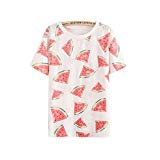

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 7.753786888455394
Amazon Url: www.amzon.com/dp/B01JUNHBRM


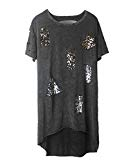

Product Title:  cauau47 womens irregular black longline paillette tshirt 
Euclidean Distance from input image: 7.769571268694018
Amazon Url: www.amzon.com/dp/B01G8WU8DM


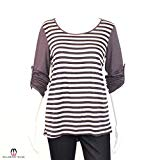

Product Title:  ya los angeles womens ya los angeles striped knit size small eggplantgray 
Euclidean Distance from input image: 7.799631440775012
Amazon Url: www.amzon.com/dp/B06XG2ZV5J


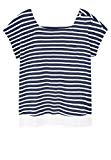

Product Title:  violeta mango womens plus size striped contrast tshirt navy 
Euclidean Distance from input image: 7.799708151952838
Amazon Url: www.amzon.com/dp/B07352NCDN


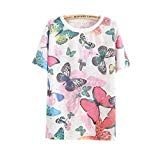

Product Title:  cute pastel tops tees colorful butterfly design print size 
Euclidean Distance from input image: 7.799755120412921
Amazon Url: www.amzon.com/dp/B019E3TD10


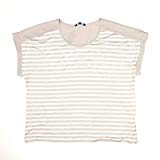

Product Title:  christian siriano womens runway style chiffon sleeve blouse xxlarge grey stripe 
Euclidean Distance from input image: 7.818151891231537
Amazon Url: www.amzon.com/dp/B00L4KJY5M


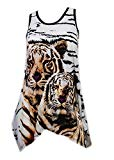

Product Title:  black  white tiger tank top tiger stripes  l 
Euclidean Distance from input image: 7.832312727110003
Amazon Url: www.amzon.com/dp/B00JXQAO94


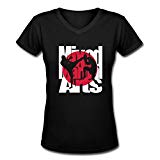

Product Title:  women japanese mixed martial arts teeblack tshirts hgiorgis xxl black 
Euclidean Distance from input image: 7.839925041667082
Amazon Url: www.amzon.com/dp/B01JQ096HW


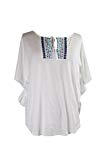

Product Title:  american living womens embroidered laceup pullover top white 
Euclidean Distance from input image: 7.842256212370013
Amazon Url: www.amzon.com/dp/B01NANU2KU


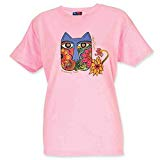

Product Title:  laurel burch  blossoming feline tee shirt  small 
Euclidean Distance from input image: 7.851530337469195
Amazon Url: www.amzon.com/dp/B06XDGH2LT


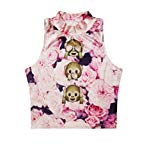

Product Title:  kingde star pink flower dog stamp sleeveless vestbqn24 
Euclidean Distance from input image: 7.855032077303984
Amazon Url: www.amzon.com/dp/B015H3W9BM


In [55]:
all_features(12566, 1, 3, 3, 1)

## Conclusion

- We combined the title, brand, color and image features and applied a weighted similarity to obtain similar products.
- We tried different weight values giving importance to different features and displayed the results accordingly.
- It was observed that better results were achieved when more importance was given to image based features as compared to title, brand & color features.